In [1]:
!pip install pytorch-lightning==1.9.2 transformers torchmetrics deepspeed nltk wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.2/826.2 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.4/765.4 KB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━

In [2]:
!git clone https://github.com/Myashka/CQA_RLHF.git cqa_v2

Cloning into 'cqa_v2'...
remote: Enumerating objects: 451, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 451 (delta 46), reused 58 (delta 24), pack-reused 367
Receiving objects: 100% (451/451), 117.29 KiB | 8.38 MiB/s, done.
Resolving deltas: 100% (297/297), done.


In [3]:
if 'google.colab' in str(get_ipython()):
    # !pip install cloud-tpu-client==0.10 torch==1.13.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl tensorboard-plugin-profile
    # !pip install google-api-python-client==1.12.1
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import yaml

In [5]:
import wandb
run = wandb.init()
artifact = run.use_artifact('myashka/CQA_RLHF/model-34980p14:v4', type='model')
artifact_dir = artifact.download()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Downloading large artifact model-34980p14:v4, 1628.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:1:18.7


## Run train

In [ ]:
trainer_config = dict(
    seed=42,
    model_name="Myashka/125M_GPTneo_reward_base",
    wandb=dict(
        api="60fce56bfaec85b8d6bc78bfac2086891f5afe54",
        project_name="CQA_RLHF",
        args=dict(job_type="train", group="reward", name="125M-lr_2e_5-1_ws-api_usage-freezed_3"),
    ),
    data=dict(
        data_dir=r"/kaggle/input/python-qa-api-usage/1.0-data-div-ans-sep-api-usage.json",
        max_length=512,
        batch_size=8,
        pad_for_tpu = True,
    ),
    model_params=dict(
        learning_rate=2e-5,
        do_freeze=False,
        use_cache=False,
        warmup_steps_per_cent=0.01,
        adam_betas=[0.9, 0.95],
        weight_decay=0.001,
        do_compute_metrics = True,
        nr_frozen_epochs = 3,
    ),
    trainer=dict(
        checkpoint=dict(
            every_n_train_steps=1000,
            dirpath=r"/kaggle/working/Checkpoints",
            log_obg = 'val_loss',
            mode = 'min',

        ),
        ckpt_path=None,
        params=dict(
            accelerator="tpu",
            max_epochs=50,
            accumulate_grad_batches=1,
            gradient_clip_val=1,
            precision="16",
            val_check_interval=104,
            overfit_batches=0,  # 0 for train
            num_sanity_val_steps=2,
            log_every_n_steps = 20,
#             limit_train_batches=100,
#             strategy="deepspeed_stage_2_offload"
        ),
    ),
)

with open("trainer_config.yaml", "w") as outfile:
    yaml.dump(trainer_config, outfile, default_flow_style=False)

In [ ]:
!python /kaggle/working/CQA_RLHF/sft/train.py --config_file /kaggle/working/trainer_config.yaml

python3: can't open file '/kaggle/working/CQA_RLHF/sft/train.py': [Errno 2] No such file or directory


## Run test

In [6]:
test_config = dict(
    seed=42,
    cuda=True,
    log_file = '/content/test-tuned-api_usage-answer_loss-bredogenerated-125M.csv',
    save_steps = 100,
    wandb=dict(
        api="60fce56bfaec85b8d6bc78bfac2086891f5afe54",
        args=dict(group="sft", job_type="test", name="125M-tuned-test-api_usage-answer_loss-bredogen"),
        project_name="CQA_RLHF",
        table_name="125M-base",
    ),
    model_name="EleutherAI/gpt-neo-125M",
    data=dict(data_dir=r"/content/drive/MyDrive/Colab Notebooks/vkr_data/data/1.0-data-div-ans-sep-api-usage-to-gen.json"),
    test_model_path=r'/content/artifacts/model-34980p14:v4/model.ckpt',
    model_params=dict(use_cache=True, do_freeze=False),
    test_params=dict(do_compute_bertscore=False, do_compute_metrics=False),
    generate_params=dict(
        do_sample=True,
        top_k=50,
        top_p=0.9,
        # temperature=0,
        # num_return_sequences=0,
        no_repeat_ngram_size=2,
        max_new_tokens=512,
        # min_new_tokens=64,
    ),
)

with open("test_config.yaml", "w") as outfile:
    yaml.dump(test_config, outfile, default_flow_style=False)

In [ ]:
!python /content/cqa_v2/sft/test.py --config_file /content/test_config.yaml

2023-04-01 15:02:32.786401: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Global seed set to 42
wandb: Currently logged in as: myashka. Use `wandb login --relogin` to force relogin
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Token indices sequence length is longer than the specified maximum sequence length for this model (2561 > 2048). Running this sequence through the model will result in indexing errors
wandb: Tracking run with wandb version 0.14.0
wandb: Run data is saved locally in ./wandb/run-20230401_150307-r8ukiyo2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run 125M-tuned-test-api_usage-answer_loss-bredogen
wandb: ⭐️ View project at https://wandb.ai/myashka/CQA_RLHF
wandb: 🚀 View run at https://wandb.ai/myashka/CQA_RLHF/runs/r8ukiyo2
  0% 0/6872 [00:00<?, ?it/s]/usr/local/lib/pyt

In [6]:
import torch
import pytorch_lightning as pl
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

In [7]:
state_dict = torch.load(r'/content/artifacts/model-34980p14:v4/model.ckpt')

In [4]:
from transformers import GPTNeoForSequenceClassification

In [8]:
model = AutoModelForCausalLM.from_pretrained(
            'EleutherAI/gpt-neo-125M', use_cache=False
        )

tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')

In [9]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [14]:
model.push_to_hub("Myashka/125M_GPTneo_sft_tuned")

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Myashka/125M_GPTneo_sft_tuned/commit/969bfcd6865db8ee6664e8602c60750a88f1a264', commit_message='Upload GPTNeoForCausalLM', commit_description='', oid='969bfcd6865db8ee6664e8602c60750a88f1a264', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.save_pretrained(r'/content/reward_base.json')

In [6]:
model.resize_token_embeddings(len(tokenizer))
tokenizer.pad_token = tokenizer.eos_token
model.config.end_token_id = tokenizer.eos_token_id
model.config.pad_token_id = model.config.eos_token_id
model.pad_token_id = tokenizer.eos_token_id

In [12]:
new_state_dict = {}
for key in state_dict['state_dict']:
    new_key = key.replace("model.", "")
    new_state_dict[new_key] = state_dict['state_dict'][key]

In [13]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [7]:
device = torch.device("cuda")

In [8]:
model = model.to(device)

In [9]:
question = """Question\nI have clustered the pixels of an image into clusters of different sizes and shapes. I want to max pool each cluster as fast as possible because the max pooling happens in one layer of my CNN. To clarify: Input is a batch of images with the following shape [batch_size, height of image, width of image, number of channels]. I have clustered each image before I start training my CNN. So for each image I have a ndarray of labels with shape [height of image, width of image]. How can I max pool over all pixels of an image that have the same label for all labels? I understand how to do it with a of for loop but that is painstakingly slow. I am searching for a fast solution that ideally can max pool over every cluster of each image in less than a second. For implementation, I use Python3.7 and PyTorch."""

In [10]:
inputs = tokenizer(question, return_tensors="pt", truncation=True,
                max_length=512, padding='max_length').to(device)

In [ ]:
import torch.nn.functional as F

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
model.eval()
output_1 = F.softmax(model(**inputs).logits[0], 1)[-1]

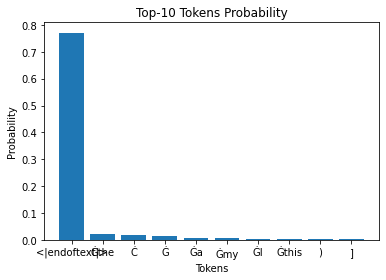

In [ ]:
top_k = torch.topk(output_1.to('cpu'), k=10)
top_k_probs = top_k.values.detach().numpy()
top_k_tokens = tokenizer.convert_ids_to_tokens(top_k.indices.numpy())

# Визуализация топ-10 токенов и их вероятностей
plt.bar(top_k_tokens, top_k_probs)
plt.xlabel("Tokens")
plt.ylabel("Probability")
plt.title("Top-10 Tokens Probability")
plt.show()

In [ ]:
def generate(text: str, device, **kwargs):
    model.eval()
    inputs = tokenizer(text+'/nAnswer: ', return_tensors="pt",
                       truncation=True,
                       max_length=512, padding='max_length')
    inputs = inputs.to(device)
    generated_tokens = model.generate(inputs.input_ids, **kwargs)
    generated_q_a = tokenizer.decode(
        generated_tokens[0], skip_special_tokens=True
    )
    return generated_q_a

In [ ]:
generate(question, device, **dict(
        do_sample=True,
        top_k=50,
        top_p=0.9,
        # temperature=0.9,
        no_repeat_ngram_size=2,
        max_new_tokens=512,
    ))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


'Question\nI have clustered the pixels of an image into clusters of different sizes and shapes. I want to max pool each cluster as fast as possible because the max pooling happens in one layer of my CNN. To clarify: Input is a batch of images with the following shape [batch_size, height of image, width of image, number of channels]. I have clustered each image before I start training my CNN. So for each image I have a ndarray of labels with shape [height of image, width of image]. How can I max pool over all pixels of an image that have the same label for all labels? I understand how to do it with a of for loop but that is painstakingly slow. I am searching for a fast solution that ideally can max pool over every cluster of each image in less than a second. For implementation, I use Python3.7 and PyTorch./nAnswer: It’s the greatest curse of the season of any season that I can read, you know, but it“'

In [ ]:
generate("""If I'm a woman you are my daughter, whom I could be?""", device, **dict(
        do_sample=True,
        top_k=50,
        top_p=0.9,
        no_repeat_ngram_size=2,
        max_length=1024,
    ))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


"If I'm a woman you are my daughter, whom I could be?/nAnswer: [.\\includ text-&#\n"

In [ ]:
import sys
sys.path.append(r'/content/cqa/sft')

In [ ]:
from data_module import QADataModule

In [ ]:
dm = QADataModule('EleutherAI/gpt-neo-125M', "/content/drive/MyDrive/Colab Notebooks/vkr_data/data/1.0-data-div-ans-sep.json", 512, 8, True, zero_question_labels=False)

In [ ]:
dm.setup('fit')

In [ ]:
next(iter(dm.train_dataloader()))['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])

In [ ]:
next(iter(dm.train_dataloader()))['labels']

tensor([[24361,    59,    77,  ..., 50256, 50256, 50256],
        [24361,    59,    77,  ..., 50256, 50256, 50256],
        [24361,    59,    77,  ..., 50256, 50256, 50256],
        ...,
        [24361,    59,    77,  ..., 50256, 50256, 50256],
        [24361,    59,    77,  ..., 50256, 50256, 50256],
        [24361,    59,    77,  ...,  5218,   220,   357]])